<a href="https://colab.research.google.com/github/aekanun2020/Data-Analytics-using-Python/blob/main/Python_Pandas_ScikitLearn_ClassificationwithPipeline%26FeatureImportance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!wget https://storage.googleapis.com/5-7sep2022/data/flight.csv
raw_pd = pd.read_csv("flight.csv")

--2022-09-04 04:42:35--  https://storage.googleapis.com/5-7sep2022/data/flight.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1617318 (1.5M) [text/csv]
Saving to: ‘flight.csv.1’

flight.csv.1        100%[===================>]   1.54M  --.-KB/s    in 0.01s   

2022-09-04 04:42:35 (108 MB/s) - ‘flight.csv.1’ saved [1617318/1617318]



## 1. Business Understanding

## 2. Data Understanding

#### 2.1 ดู contents 5 rows แรก

In [3]:
raw_pd.head(5)

,date,airline,departure_airport,arrival_airport,departure_delay,arrival_delay,dayofweek,month,delayed
0,2009-02-05,WN,SFO,LAX,2,1,5,2,0
1,2009-02-05,WN,SFO,LAX,47,43,5,2,1
2,2009-02-05,WN,SFO,LAX,52,42,5,2,1
3,2009-02-05,WN,SFO,LAX,92,84,5,2,1
4,2009-02-05,WN,SFO,LAX,80,76,5,2,1


#### 2.2 ดู Shape ของข้อมูล พบว่า เป็นแบบ 2 Dimensions

In [4]:
raw_pd.shape

(47785, 9)

#### 2.3 ดู Data Type ของแต่ละ Attributes

In [5]:
raw_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47785 entries, 0 to 47784
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               47785 non-null  object
 1   airline            47785 non-null  object
 2   departure_airport  47785 non-null  object
 3   arrival_airport    47785 non-null  object
 4   departure_delay    47785 non-null  int64 
 5   arrival_delay      47785 non-null  int64 
 6   dayofweek          47785 non-null  int64 
 7   month              47785 non-null  int64 
 8   delayed            47785 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 3.3+ MB


#### 2.4 ตรวจสอบค่า Null ในแต่ละ Attributes

In [6]:
raw_pd.isnull().sum()

date                 0
airline              0
departure_airport    0
arrival_airport      0
departure_delay      0
arrival_delay        0
dayofweek            0
month                0
delayed              0
dtype: int64

In [7]:
# กำหนด Cols ที่ contain NULL แต่ธุรกิจจำเป็นต้องใช้
nullNeedCol_list = []
## ความจริงคือ ML Algorithm ทุกตัวพิจารณาข้อมูล ถ้าไม่มีข้อมูลก็พิจารณาอะไรไม่ได้ การแทนที่จุดที่ไม่มีข้อมูล (Null Replacement) เป็นสิ่งที่ทำได้
## แต่ถ้าจุดที่ไม่มีข้อมูลมันเยอะเกินไป เช่น 80% ของ Col ไม่มีข้อมูลเช่นนี้ ก็คงจะไม่เหมาะที่ใช้ทำ Null Replacement ไม่ว่าด้วยเทคนิคใดๆ ก็ตาม
## ดังนั้นเหตุคือ ในหลายๆ กรณีอาจมีการใช้ dropna() เพื่อทิ้งทั้ง row ไปเมื่อ row นั้นมีค่า null อยู่ (มี null อยู่เพียง col ใด col หนึ่ง ก็ทิ้งไปทั้ง col)
## ผลที่เกิดขึ้นคือ row จะเหลือน้อยลงกว่าเดิม เพื่อเป็นการหลีกเลี่ยงผลแบบนี้ จึงควรพิจารณาว่า col ใด ที่มีค่า null อยู่เป็นส่วนใหญ่ แล้วก็เลือกที่จะทิ้ง col นั้นไป (แทนการทิ้ง row)
## อย่างไรก็ตาม บางกรณีอาจมีบาง col เลือกที่จะเก็บไว้ไม่ลบ จึงต้องมีการระบุชื่อ col ที่ต้องการเก็บไว้ที่ nullNeedCol_list นี้ 

#### **2.5 Univariate Analysis** 

เพื่อดู Bias เนื่องจาก (1) โมเดลที่ได้รับมา จะเป็นโมเดลที่เหมาะกับข้อมูล Distribution แบบนี้เท่านั้น เช่น ถ้าพบว่า ข้อมูลที่นำมาสร้างมาโมเดลเป็นข้อมูลจากเดือนๆ เพียงเดือนเดียว ความสามารถของโมเดลก็อยู่ในขอบเขตของเดือนเดียวนั้นเท่านั้น เป็นต้น (2) หากพบว่า ธุรกิจเกี่ยวข้องกับข้อมูลที่มี Distribution แตกต่างจาก Distribution ตาม (1) อย่างมาก ธุรกิจก็ควรที่จะ retrain model ด้วยข้อมูลที่มี Distribution ใหม่ๆ (3) Higher Variance ทำให้ต้องสงสัยว่ามี Outlier มากขึ้น ซึ่งหากนี้ Outlier ส่งผลต่อ Divide-and-Conquer => แก้โดย remove หรือ bucketization (4) Highest Variance ทำให้ต้องสงสัยว่ามี Dispersion มากที่สุด ซึ่ง Dispersion ส่งผลต่อการคำนวณเชิงระยะทาง หรือ cost functions

In [8]:
# Define categorical columns
categorical_list = list(raw_pd.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical_list}")

# Define numerical columns
numerical_list = list(raw_pd.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical_list}")

Categorical columns are: ['date', 'airline', 'departure_airport', 'arrival_airport']
Numerical columns are: ['departure_delay', 'arrival_delay', 'dayofweek', 'month', 'delayed']


**Frequency Distribution of Categorical Values**

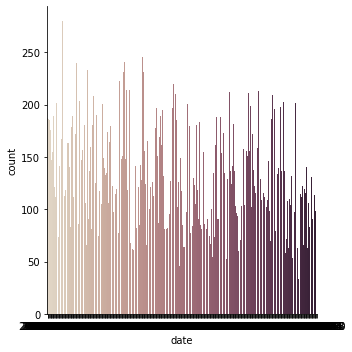

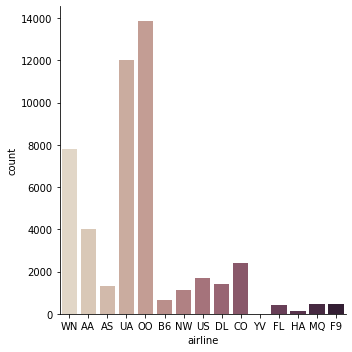

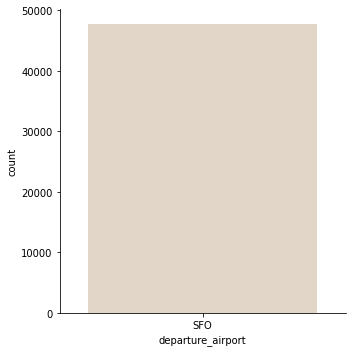

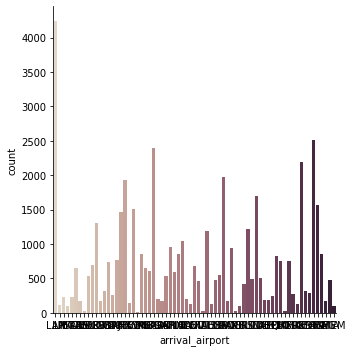

In [9]:
for col in categorical_list:
  sns.catplot(x=col,kind="count", data=raw_pd, palette="ch:.25")

**Frequency Distribution of Numerical Values**

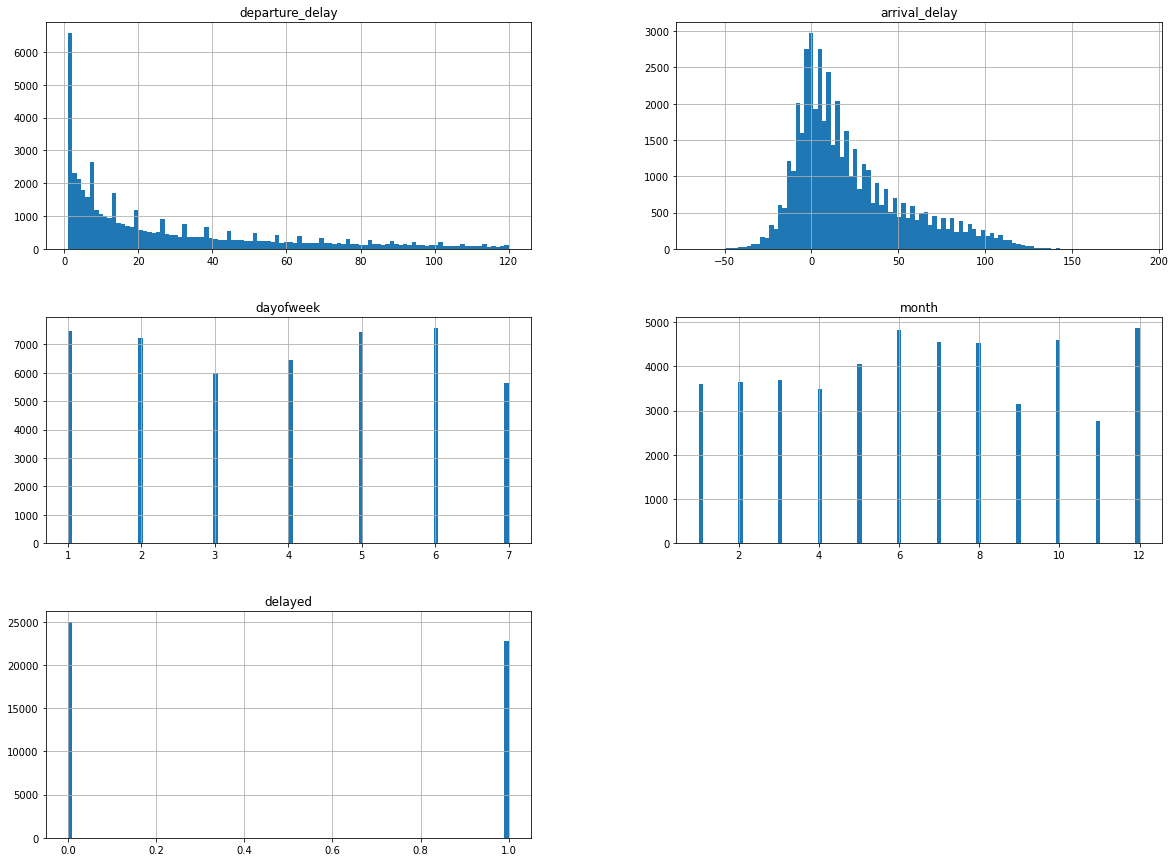

In [12]:
raw_pd.hist(bins=100, figsize=(20,15))
plt.show()

**Dispersion Analysis**

In [13]:
raw_pd.describe()

,departure_delay,arrival_delay,dayofweek,month,delayed
count,47785.000000,47785.000000,47785.000000,47785.000000,47785.000000
mean,27.721147,22.218269,3.930438,6.624150,0.477158
std,29.436796,31.939881,1.995762,3.392922,0.499483
min,1.000000,-65.000000,1.000000,1.000000,0.000000
25%,5.000000,-1.000000,2.000000,4.000000,0.000000
50%,16.000000,13.000000,4.000000,7.000000,0.000000
75%,42.000000,38.000000,6.000000,10.000000,1.000000
max,120.000000,189.000000,7.000000,12.000000,1.000000


**2.6 Multivariate Analysis**

**2.6.1 ทดสอบระหว่าง 2 ตัวแปร**

*ทดสอบระหว่าง delayed กับ departure_airport*

In [14]:
pd.DataFrame(raw_pd.groupby(['departure_airport','delayed']).size())

0
departure_airport delayed       
SFO               0        24984
                  1        22801

In [15]:
departure_airport_delayed_analysis_pd = pd.DataFrame(raw_pd.groupby(by=['departure_airport','delayed']).count())

In [16]:
departure_airport_delayed_analysis_pd

date  airline  arrival_airport  departure_delay  \
departure_airport delayed                                                     
SFO               0        24984    24984            24984            24984   
                  1        22801    22801            22801            22801   

                           arrival_delay  dayofweek  month  
departure_airport delayed                                   
SFO               0                24984      24984  24984  
                  1                22801      22801  22801

In [17]:
departure_airport_delayed_analysis_pd[['date']]

date
departure_airport delayed       
SFO               0        24984
                  1        22801

In [18]:
departure_airport_delayed_analysis_pd = pd.DataFrame(raw_pd.groupby(['departure_airport','delayed']\
                                                                    ,as_index = False).count()\
.pivot('departure_airport','delayed').fillna(0))['date']

In [19]:
departure_airport_delayed_analysis_pd

delayed,0,1
departure_airport,,
SFO,24984,22801


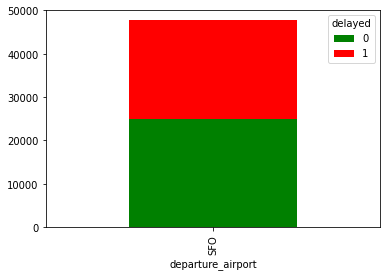

In [20]:
departure_airport_delayed_analysis_pd.plot(kind='bar', stacked=True, color=['green', 'red'])

*ทดสอบระหว่าง delayed กับ month*

In [21]:
pd.DataFrame(raw_pd.groupby(['month','delayed']).size())

0
month delayed      
1     0        1755
      1        1840
2     0        1638
      1        2012
3     0        1888
      1        1807
4     0        1718
      1        1771
5     0        1906
      1        2149
6     0        2436
      1        2393
7     0        2539
      1        2022
8     0        2404
      1        2122
9     0        1720
      1        1429
10    0        2445
      1        2153
11    0        1799
      1         963
12    0        2736
      1        2140

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


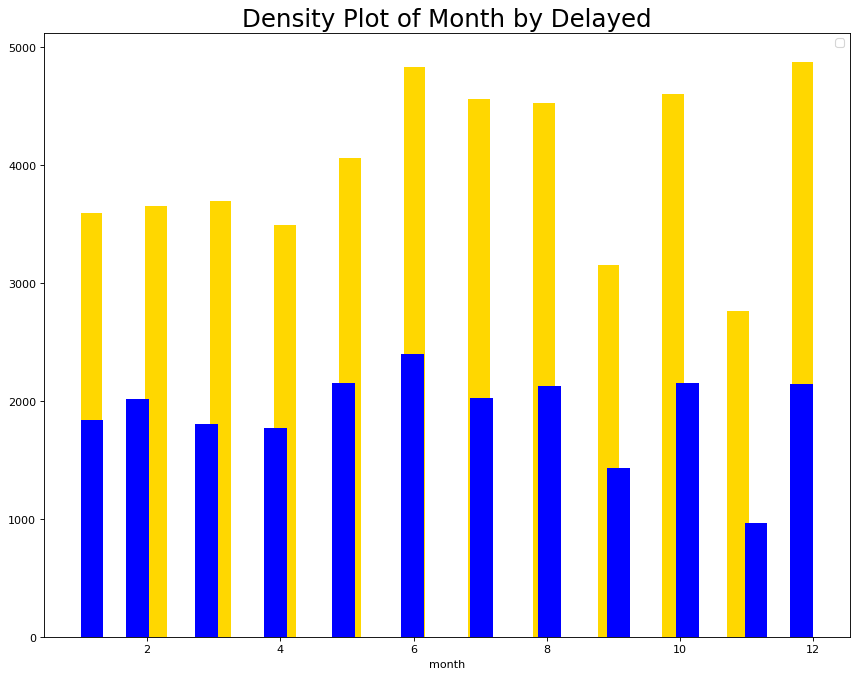

In [22]:
# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(raw_pd.month, color="gold", kde=False, hist_kws={"alpha": 1}) 
sns.distplot(raw_pd[raw_pd.delayed == 1].month, color="blue", kde=False, hist_kws={"alpha":1})

# Decoration
plt.title('Density Plot of Month by Delayed', fontsize=22)
plt.legend()
plt.show()

*ทดสอบระหว่าง delayed กับ dayofweek*

In [23]:
pd.DataFrame(raw_pd.groupby(['dayofweek','delayed']).size())

0
dayofweek delayed      
1         0        3713
          1        3744
2         0        3870
          1        3361
3         0        3314
          1        2694
4         0        3383
          1        3050
5         0        3882
          1        3550
6         0        3739
          1        3848
7         0        3083
          1        2554

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


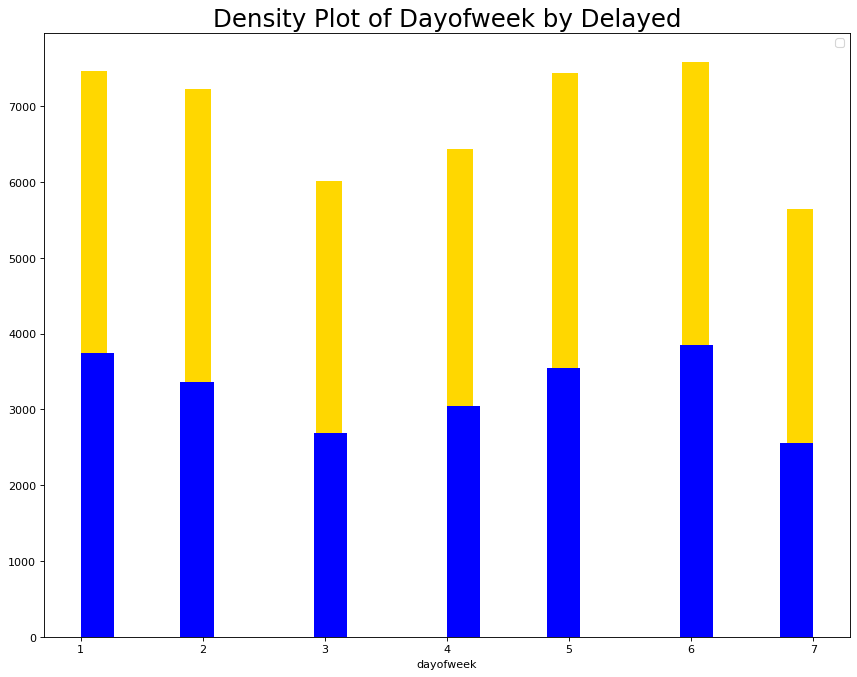

In [24]:
# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(raw_pd.dayofweek, color="gold", kde=False, hist_kws={"alpha": 1}) 
sns.distplot(raw_pd[raw_pd.delayed == 1].dayofweek, color="blue", kde=False, hist_kws={"alpha":1})

# Decoration
plt.title('Density Plot of Dayofweek by Delayed', fontsize=22)
plt.legend()
plt.show()

**2.6.2 ทดสอบระหว่าง 3 ตัวแปร**

1 Continuous by 2 Discrete

*ทดสอบระหว่าง delayed, departure_delay และ dayofweek*

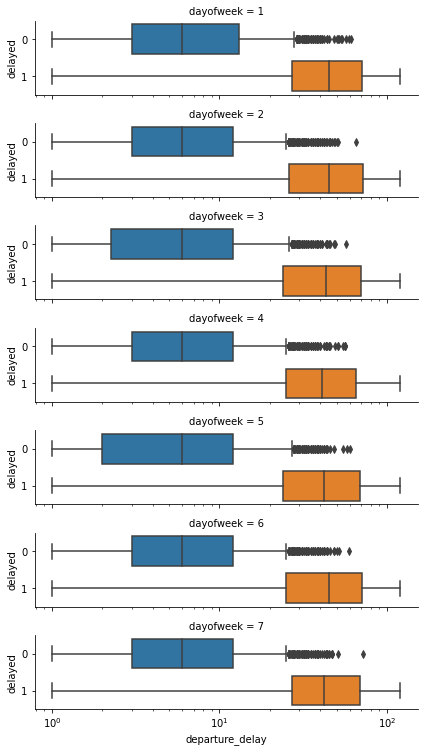

In [25]:
g = sns.catplot(x="departure_delay", y="delayed", row="dayofweek",
                kind="box", orient="h", height=1.5, aspect=4,
                data=raw_pd)
g.set(xscale="log")

*ทดสอบระหว่าง delayed, departure_delay และ month*

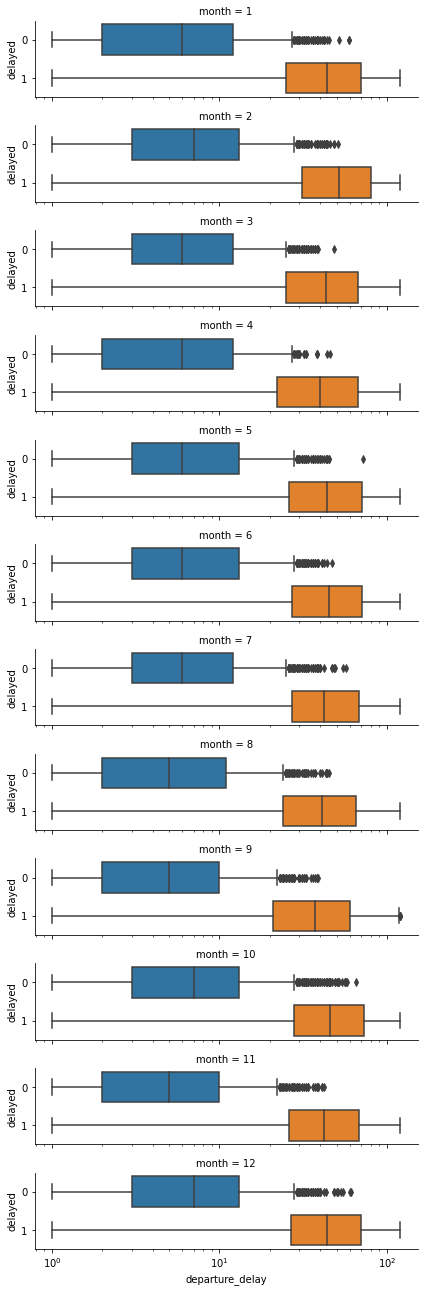

In [26]:
g = sns.catplot(x="departure_delay", y="delayed", row="month",
                kind="box", orient="h", height=1.5, aspect=4,
                data=raw_pd)
g.set(xscale="log")

*ทดสอบระหว่าง delayed, departure_delay และ airline*

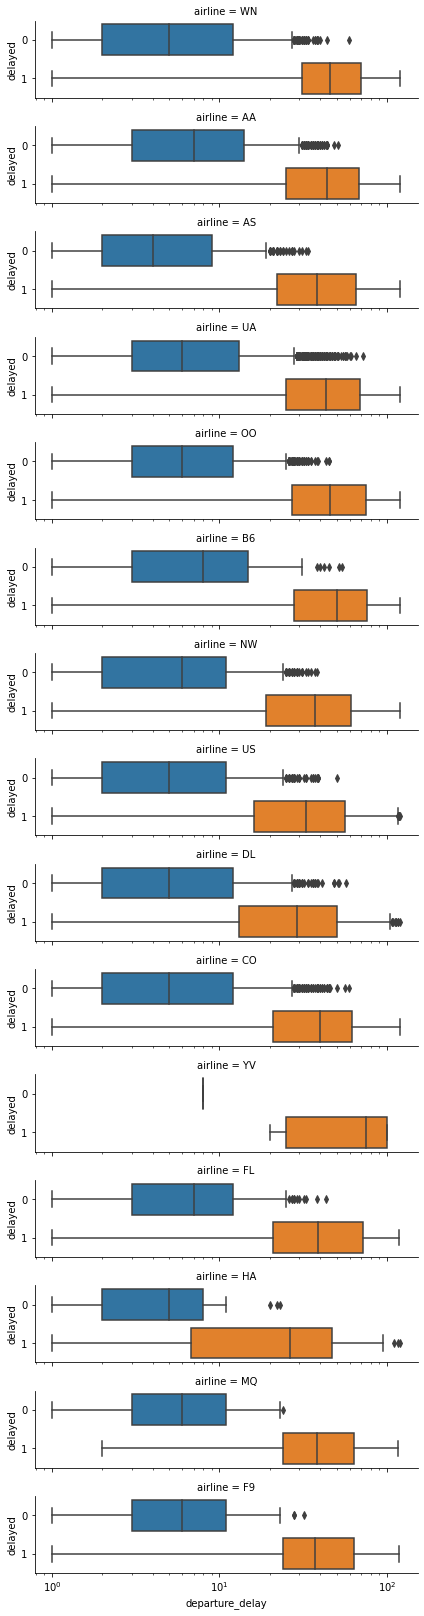

In [27]:
g = sns.catplot(x="departure_delay", y="delayed", row="airline",
                kind="box", orient="h", height=1.5, aspect=4,
                data=raw_pd)
g.set(xscale="log")

*ทดสอบระหว่าง delayed, departure_delay และ departure_airport*

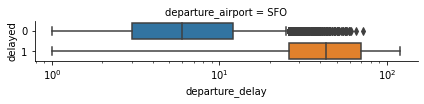

In [28]:
g = sns.catplot(x="departure_delay", y="delayed", row="departure_airport",
                kind="box", orient="h", height=1.5, aspect=4,
                data=raw_pd)
g.set(xscale="log")

In [29]:
pd.DataFrame(raw_pd[raw_pd.delayed == 1].dayofweek)

,dayofweek
1,5
2,5
3,5
4,5
6,5
...,...
47776,5
47778,6
47780,5
47781,6


In [30]:
pd.DataFrame(raw_pd[raw_pd['delayed'] == 1]['dayofweek'])

,dayofweek
1,5
2,5
3,5
4,5
6,5
...,...
47776,5
47778,6
47780,5
47781,6


In [31]:
pd.DataFrame(raw_pd[raw_pd.delayed == 1]['dayofweek'])

,dayofweek
1,5
2,5
3,5
4,5
6,5
...,...
47776,5
47778,6
47780,5
47781,6


### 2.7

### 2.8

#### 2.9 กำหนด Candidated Features

In [32]:
noNullCol_list = []

In [33]:
# เลือก column ที่ไม่มี null เท่านั้น
for item_col in raw_pd.columns.to_list():
    if raw_pd[item_col].isnull().sum() == 0:
        noNullCol_list.append(item_col)
        

In [34]:
noNullCol_list

['date',
 'airline',
 'departure_airport',
 'arrival_airport',
 'departure_delay',
 'arrival_delay',
 'dayofweek',
 'month',
 'delayed']

In [35]:
candidatedFeatures_list = noNullCol_list+nullNeedCol_list

In [36]:
# ทำการเลือก Feature แบบเลือกออก
# เอา departure_airport ออกทั้ง column เนื่องจาก departure_airport มีค่าเดียวคือ SFO ซึ่งไม่มีประโยชน์ต่อการแบ่งแยก (Divide-and-Conquer)
# เอา date ออก เนื่องจากวันที่ น่าจะไม่มีความสัมพันธ์กับ delayed
# เอา arrival_delay ออก เนื่องจาก arrival_delay เป็นสิ่งที่ทำให้เกิด information leakage
candidatedFeatures_pd = raw_pd.filter(candidatedFeatures_list)\
.drop(['date','arrival_delay','departure_airport'], axis=1).dropna()

#### 2.10 EDA of Candidate Features with Checking for NULL

In [37]:
candidatedFeatures_pd.isnull().sum()

airline            0
arrival_airport    0
departure_delay    0
dayofweek          0
month              0
delayed            0
dtype: int64

In [38]:
candidatedFeatures_pd.count()

airline            47785
arrival_airport    47785
departure_delay    47785
dayofweek          47785
month              47785
delayed            47785
dtype: int64

## 3. Data Preparation

## 4. Modeling (Features Transformation and ML Algorithms)

In [39]:
import pandas as pd
from seaborn import load_dataset
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

#### 4.1 แบ่งแยก Training/Testing Set

In [40]:
train_df = candidatedFeatures_pd.sample(frac=0.8,random_state=123)

In [41]:
test_df = candidatedFeatures_pd.drop(train_df.index)

In [42]:
train_df.count()

airline            38228
arrival_airport    38228
departure_delay    38228
dayofweek          38228
month              38228
delayed            38228
dtype: int64

In [43]:
test_df.count()

airline            9557
arrival_airport    9557
departure_delay    9557
dayofweek          9557
month              9557
delayed            9557
dtype: int64

#### 4.2 แบ่งแยก Descriptive Features and Target Feature (Label) ออกจากกัน ตามหลักการของ Scikit Learn

In [44]:
train_labels = train_df.filter(['delayed'])
train_df = train_df.loc[:, train_df.columns != 'delayed']

In [45]:
test_labels = test_df.filter(['delayed'])
test_df = test_df.loc[:, test_df.columns != 'delayed']

In [46]:
X_train = train_df

In [47]:
X_test = test_df

In [48]:
y_train = train_labels

In [49]:
y_test = test_labels

#### 4.3 ตรวจสอบว่า Features ไหนเป็น Categorical หรือ Numerical เพื่อเลือกทำ Transformation ให้เหมาะสมต่อไป

In [50]:
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['airline', 'arrival_airport']
Numerical columns are: ['departure_delay', 'dayofweek', 'month']


#### 4.4 Define/Run a pipeline for transforming features and modeling

In [51]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [52]:
# Define custom transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# Define categorical pipeline
cat_pipe = Pipeline([('selector', ColumnSelector(categorical)),
                     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([('selector', ColumnSelector(numerical))
                     #('imputer', SimpleImputer(strategy='median')),
                     #('scaler', MinMaxScaler())
                    ])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion(transformer_list=[('cat', cat_pipe),
                                              ('num', num_pipe)])

# Model Training
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', DecisionTreeClassifier(criterion="entropy", max_depth=None))])
pipeline_model = pipe.fit(X_train, y_train)

## 5. Model Evaluation

#### 5.1 คำนวณค่าตามเกณฑ์การประเมิน

In [53]:
y_pred = pipeline_model.predict(X_test).flatten()


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (predict/actual):\n", pd.DataFrame(cm))


pipeline_model.score(X_test, y_test)

recall = np.diag(cm) / np.sum(cm, axis=1)
print("\nRecall:\n", pd.Series(recall))

precision = np.diag(cm) / np.sum(cm, axis=0)
print("\nPrecision:\n", pd.Series(precision))


from sklearn.metrics import f1_score
weighted_f1 = f1_score(y_test, y_pred, average="weighted")
print("\nF1 score:\n", weighted_f1)

Confusion Matrix (predict/actual):
       0     1
0  4129   833
1   854  3741

Recall:
 0    0.832124
1    0.814146
dtype: float64

Precision:
 0    0.828617
1    0.817884
dtype: float64

F1 score:
 0.8234643984765437


#### 5.2 คำนวณ Feature Importance

In [54]:
pipeline_model_featureUnion = pipeline_model.named_steps['model']

In [55]:
#pipeline_model_featureUnion.feature_importances_

In [56]:
pipeline_features_coeff = pipeline_model_featureUnion.feature_importances_

In [57]:
# Getting machine-readable columns
cat_columns = preprocessor.transformer_list[0][1][2].get_feature_names(categorical)
columns = np.append(cat_columns, numerical)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
zipped = zip(columns,pipeline_features_coeff)

In [59]:
coeff_pd = pd.DataFrame(zipped,columns=["machine_features","value"])

In [60]:
coeff_pd

,machine_features,value
0,airline_AA,0.006102
1,airline_AS,0.003670
2,airline_B6,0.002059
3,airline_CO,0.003456
4,airline_DL,0.003000
...,...,...
82,arrival_airport_STL,0.000571
83,arrival_airport_TUS,0.000489
84,departure_delay,0.627155
85,dayofweek,0.082165


In [61]:
# Sort the features by the absolute value of their coefficient
coeff_pd["abs_value"] = coeff_pd["value"].apply(lambda x: abs(x))
coeff_pd["colors"] = coeff_pd["value"].apply(lambda x: "green" if x > 0 else "red")
coeff_pd = coeff_pd.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

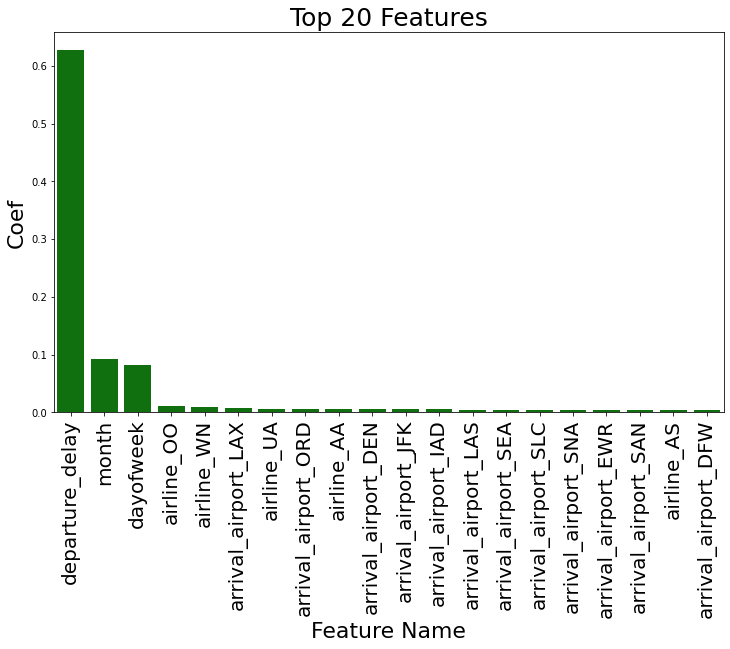

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="machine_features",
            y="value",
            data=coeff_pd.head(20),
           palette=coeff_pd.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [63]:
coeff_pd

,machine_features,value,abs_value,colors
84,departure_delay,0.627155,0.627155,green
86,month,0.092796,0.092796,green
85,dayofweek,0.082165,0.082165,green
10,airline_OO,0.011025,0.011025,green
13,airline_WN,0.008647,0.008647,green
...,...,...,...,...
26,arrival_airport_BZN,0.000201,0.000201,green
51,arrival_airport_MCI,0.000087,0.000087,green
14,airline_YV,0.000072,0.000072,green
17,arrival_airport_ANC,0.000071,0.000071,green


#### 5.3 เปรียบเทียบผลการทดลองในหลายๆ Algorithms

In [64]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
import warnings
warnings.simplefilter("ignore")


In [65]:
classifiers = {
    "Dummy"        : DummyClassifier(strategy='uniform', random_state=2),
    "KNN(3)"       : KNeighborsClassifier(3), 
    "RBF SVM"      : SVC(gamma=2, C=1), 
    "Decision Tree": DecisionTreeClassifier(max_depth=7), 
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=10, max_features=4), 
    "Neural Net"   : MLPClassifier(alpha=1), 
    "AdaBoost"     : AdaBoostClassifier(),
    "Naive Bayes"  : GaussianNB(), 
    "QDA"          : QuadraticDiscriminantAnalysis(),
    "Linear SVC"   : LinearSVC(),
    "Linear SVM"   : SVC(kernel="linear"), 
    "Gaussian Proc": GaussianProcessClassifier(1.0 * RBF(1.0)),
}


In [66]:
from time import time
nfast = 10
head = list(classifiers.items())[:nfast]

for name, classifier in head:
    start = time()
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', classifier)])
    pipeline_model = pipe.fit(X_train, y_train.values.flatten())
    train_time = time() - start
    start = time()
    score = pipeline_model.score(X_test, y_test.values.flatten())
    score_time = time()-start
    print("{:<15}| score = {:.3f} | time = {:,.3f}s/{:,.3f}s".format(name, score, train_time, score_time))

Dummy          | score = 0.501 | time = 0.052s/0.016s
KNN(3)         | score = 0.849 | time = 0.053s/8.705s
RBF SVM        | score = 0.777 | time = 782.024s/52.992s
Decision Tree  | score = 0.872 | time = 0.201s/0.023s
Random Forest  | score = 0.697 | time = 0.208s/0.026s
Neural Net     | score = 0.873 | time = 15.098s/0.039s
AdaBoost       | score = 0.873 | time = 2.924s/0.169s
Naive Bayes    | score = 0.725 | time = 0.102s/0.027s
QDA            | score = 0.665 | time = 0.463s/0.055s
Linear SVC     | score = 0.800 | time = 2.782s/0.018s


In [67]:
raw_pd[(raw_pd.delayed == 0)]['arrival_delay'].describe()

count    24984.000000
mean        -1.092379
std          9.995542
min        -65.000000
25%         -7.000000
50%          0.000000
75%          7.000000
max         14.000000
Name: arrival_delay, dtype: float64

In [68]:
raw_pd[(raw_pd.delayed == 1)]['arrival_delay'].describe()

count    22801.000000
mean        47.760712
std         27.940531
min         15.000000
25%         24.000000
50%         40.000000
75%         66.000000
max        189.000000
Name: arrival_delay, dtype: float64

In [69]:
raw_pd.groupby(['month','delayed']).size()

month  delayed
1      0          1755
       1          1840
2      0          1638
       1          2012
3      0          1888
       1          1807
4      0          1718
       1          1771
5      0          1906
       1          2149
6      0          2436
       1          2393
7      0          2539
       1          2022
8      0          2404
       1          2122
9      0          1720
       1          1429
10     0          2445
       1          2153
11     0          1799
       1           963
12     0          2736
       1          2140
dtype: int64

In [70]:
raw_pd.groupby(['dayofweek','delayed']).size()

dayofweek  delayed
1          0          3713
           1          3744
2          0          3870
           1          3361
3          0          3314
           1          2694
4          0          3383
           1          3050
5          0          3882
           1          3550
6          0          3739
           1          3848
7          0          3083
           1          2554
dtype: int64